In [ ]:
import time
# Start timer to time the notebook execution
start = time.time()

import numpy as np
from datetime import datetime
import pandas as pd
import os
import yaml
from dotmap import DotMap
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option(
    'display.precision', 2,
    'display.max_colwidth', 200
)

from deepeval.metrics import (
    ContextualPrecisionMetric,
    FaithfulnessMetric,
    ContextualRecallMetric,
    AnswerRelevancyMetric,
    HallucinationMetric,
)

import sys
utils_path = "../../08-Utils"
if utils_path not in sys.path:
    sys.path.append(utils_path)

from helpers import (
    CustomEvaluationModel,
    run_evaluations,
    deepeval_on_test_sets,
    deepeval_to_dict,
)

In [2]:
# Open the Starter Pack global configuration file
with open('../../07-Starter_Pack_config/improved_rag_config.yaml', 'r') as file:
    config = yaml.safe_load(file)
config = DotMap(config)

In [3]:
# File paths for the inference results from each RAG variant
# on the same Q/A pairs evaluation dataset.
base_path = config.file_paths.rag_base_path
simple_rag_file = config.file_paths.simple_rag
sentence_window_rag = config.file_paths.sentence_window_rag
auto_merging_retrieval = config.file_paths.auto_merging_retrieval
suffix = config.file_paths.common_suffix
judge_llm_cfg = config.deep_eval.osrc_judge_llm
judge_llm = CustomEvaluationModel(llm_cfg=judge_llm_cfg)

In [4]:
test_sets_folders = [
    base_path + simple_rag_file + suffix,
    base_path + sentence_window_rag + suffix,
    base_path + auto_merging_retrieval + suffix,
]

test_sets = []
for folder in test_sets_folders:
    file_list = os.listdir(folder)
    current_file = file_list[0] if len(file_list) > 0 else None
    if current_file is not None:
        test_sets.append(f"{folder}/{current_file}")

eval_parameters = {
    "threshold": config.deep_eval.decision_threshold,
    "model": judge_llm,
    "include_reason": config.deep_eval.include_reason,
    "async_mode": False,
}

# DeepEval list of metrics to get applied on each
# test case.
metrics = [
    ContextualPrecisionMetric(**eval_parameters),
    ContextualRecallMetric(**eval_parameters),
    AnswerRelevancyMetric(**eval_parameters),
    FaithfulnessMetric(**eval_parameters),
    HallucinationMetric(**eval_parameters),
]


In [5]:
# Execute DeepEval evaluations on test cases
print("Running evaluations...")
evals = deepeval_on_test_sets(
    test_sets,
    metrics,
    config.deep_eval.num_eval_samples,
)

Running evaluations...


  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Standard RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Evaluating Sentence_Window_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

Evaluating Auto_Merging_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3


✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

### Display DeepEval summarized results

- Notice __there is no absolute winner RAG approach__. Further tweaking is required to get a configuration
that maximizes the metric(s) of interest.
- It might be (too) hard to make a single RAG approach get
the highest scores all across the board.  

In [6]:
# Display the evaluation results. 
# Use a summarized view of the results to facilitate the comparison
print("DeepEval Results")
summary = deepeval_to_dict(evals)
labels = [modelmix for modelmix in summary.keys()]
dframes = [pd.DataFrame.from_dict(summary[label]).describe(percentiles=[]) for label in labels]
results_df = pd.concat(dframes, keys=labels)
display(results_df) 

DeepEval Results


Contextual Precision Score  \
Standard RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3        count                       37.00   
                                                                                     mean                         0.80   
                                                                                     std                          0.28   
                                                                                     min                          0.00   
                                                                                     50%                          0.89   
                                                                                     max                          1.00   
Sentence_Window_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3 count                       39.00   
                                                                                     mean                         0.89   
                                                                                     std                          0.23   
                                                                                     min                          0.00   
                                                                                     50%                          1.00   
                                                                                     max                          1.00   
Auto_Merging_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3    count                       40.00   
                                                                                     mean                         0.83   
                                                                                     std                          0.27   
                                                                                     min                          0.00   
                                                                                     50%                          0.97   
                                                                                     max                          1.00   

                                                                                            Contextual Recall Score  \
Standard RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3        count                    40.00   
                                                                                     mean                      0.83   
                                                                                     std                       0.32   
                                                                                     min                       0.00   
                                                                                     50%                       1.00   
                                                                                     max                       1.00   
Sentence_Window_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3 count                    40.00   
                                                                                     mean                      0.79   
                                                                                     std                       0.33   
                                                                                     min                       0.00   
                                                                                     50%                       1.00   
                                                                                     max                       1.00   
Auto_Merging_RAG__llama3-8b-instruct__nv-embedqa-e5-v5__nv-rerankqa-mistral-4b-v3    count                    40.00   
                                                                                     mean                  

In [7]:
# Separate the men values per each metric to facilidate comparisons. 
means_df = results_df[np.in1d(results_df.index.get_level_values(1), ['mean'])].reset_index(level=1, drop=True)
means_df.index = means_df.index.to_series().str.split(pat='__').map(lambda x: x[0])
means_df

,Contextual Precision Score,Contextual Recall Score,Answer Relevancy Score,Faithfulness Score,Hallucination Score
Standard RAG,0.80,0.83,0.84,0.94,0.43
Sentence_Window_RAG,0.89,0.79,0.80,0.96,0.31
Auto_Merging_RAG,0.83,0.84,0.82,0.96,0.40


[]

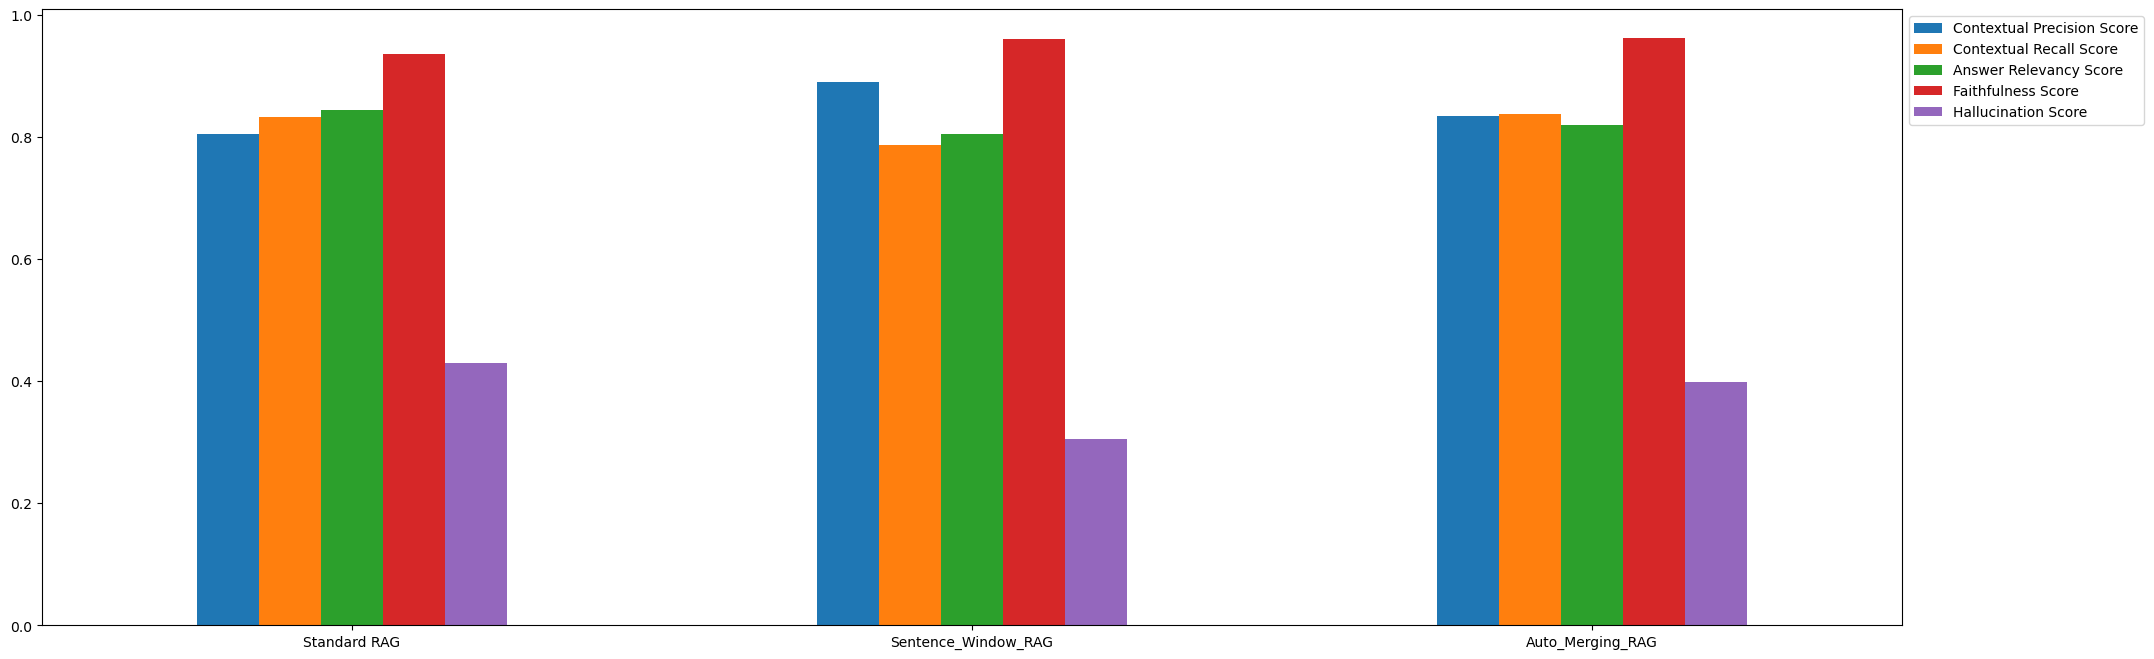

In [8]:
# Plot and compare the mean values of every metric.
ax = means_df.plot.bar(rot=0, figsize=(24, 8))
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [9]:
# Serialize the "evals" results.
file_suffix = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
file_name = f"eval_runs/DeepEval_run.csv_{file_suffix}"
evals_df = pd.DataFrame.from_dict(summary)
evals_df.to_csv(
        path_or_buf=file_name,
        index=False,
)